In [21]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
#import data
from biom import load_table
from gneiss.util import match
#deicode
from deicode.optspace import OptSpace
#from deicode.opt_space import optspace
from deicode.preprocessing import rclr,inverse_rclr
#transforms 
from skbio.stats.composition import clr,ilr,centralize, ilr_inv,closure
#PCoA
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
#else
#regression
from gneiss.regression import ols
from gneiss.composition import ilr_transform
from gneiss.cluster import correlation_linkage


%matplotlib inline
# make the notebook readable
from IPython.core.display import HTML
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-paper')
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")


 Sponges (case study)

 A comprehensive analysis of microbial symbiont communities associated with 82 species from the phylum Porifera

 P.I.  Torsten Thomas (University of New South Wales)
 [Data and Source](https://qiita.ucsd.edu/study/description/10346)

First we import the .biom OTU table and tab delimited mapping file (qiime style).

In [2]:
from biom import load_table
from gneiss.util import match

# import observation data
in_biom='data/Thomas_sponge_communities.biom' #import biom file
table = load_table(in_biom)
sample_filter = lambda val, id_, md: sum(val) > 500
table = table.filter(sample_filter, axis='sample')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)

# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

#mapping import 
map_file='data/Thomas_sponge_communities_clean.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)

#match the tables
otutabledf,mappingdf=match(otutabledf,mappingdf)
otutabledf = otutabledf.loc[:, otutabledf.sum(axis=0) > 10]


Now we can extract OTUs (features) that separate sponges across life stages.

 Now that we know from the cross-validation scores that life stage is an important category we would like to find out what pattern of OTUs best explain this variation.  Here we plot the taxonomic pattern that the machine learning algorithm found to be most predictive for the sponge sample's life stage. The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.

In [18]:
table_norm=rclr().fit_transform(otutabledf.copy())
opt=OptSpace(rank=2).fit(table_norm)
solution=opt.transform()
solution_inv=inverse_rclr().fit_transform(solution)

completedf=pd.DataFrame(solution_inv,index=otutabledf.index
                        ,columns=otutabledf.columns)
sample_loading=pd.DataFrame(opt.sample_weights,index=otutabledf.index)
feature_loading=pd.DataFrame(opt.feature_weights,index=otutabledf.columns)

method='euclidean'
raw_res = pcoa(DistanceMatrix(pdist(otutabledf.as_matrix(), method),
                              list(otutabledf.index)))

#save values to df
feature_loading = feature_loading.sort_values(by=0)
life_stage = mappingdf['Life Stage'].sort_values()
sample_loading = sample_loading.rename(columns={0: 'PC1', 1: 'PC2'})



In [19]:
def plot_lifestage(samples, md, ax):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    idx = md['Life Stage'] == 'Adult'
    ax.scatter(samples.loc[idx, 'PC1'], samples.loc[idx, 'PC2'], label='Adult')   
    ax.scatter(samples.loc[~idx, 'PC1'], samples.loc[~idx, 'PC2'], label='Larvae')    
    
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2', fontsize=14)    
    ax.set_xlabel('PC1', fontsize=14)
    return ax

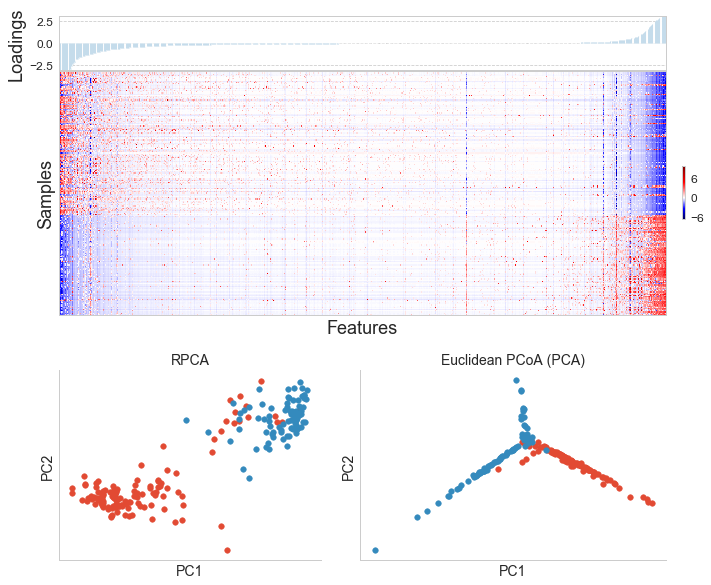

In [20]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker

plt.style.use('ggplot')
sns.set_style('whitegrid')

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


fig = plt.figure(figsize=(10, 10), facecolor='white')
gs = gridspec.GridSpec(100, 100)
ax_map = plt.subplot(gs[10:55, :97])
ax_bar = plt.subplot(gs[0:10, :97])
ax_cbar = plt.subplot(gs[10:55, 97:])

ax_raw_complete = plt.subplot(gs[65:, :42])
ax_raw_bray = plt.subplot(gs[65:, 48:97])

ind = np.arange(feature_loading.shape[0])
ax_bar.bar(ind, feature_loading[0],color='#1f78b4',alpha=1)
ax_bar.set_xlim([0, feature_loading.shape[0]])
ax_bar.set_ylim([feature_loading[0].min(), feature_loading[0].max()])
ax_bar.set_xticks([])

ax_bar.set_ylim([-3, 3])
ax_bar.grid(which='major', axis='both', linestyle='--')
ax_bar.set_ylabel('Loadings', fontsize=18)
ax_bar.tick_params(labelsize=12)

sorted_df = otutabledf.reindex(index=life_stage.index, columns=feature_loading.index)
img = ax_map.imshow(clr(centralize(sorted_df+1)), aspect='auto', 
                    norm=MidpointNormalize(midpoint=0.),
                    interpolation='nearest', cmap='seismic')
ax_map.set_xticks([])
ax_map.set_yticks([])
ax_map.set_xlabel('Features', fontsize=18)
ax_map.set_ylabel('Samples', fontsize=18)
ax_map.grid()

cbar = fig.colorbar(img, ax=ax_cbar) 
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
ax_cbar.grid()
ax_cbar.set_xticks([])
ax_cbar.set_yticks([])
ax_cbar.axis('off')

ax_cbar.grid()
ax_cbar.set_xticks([])
ax_cbar.set_yticks([])

ax_raw_complete = plot_lifestage(sample_loading, mappingdf, ax_raw_complete)
ax_raw_bray = plot_lifestage(raw_res.samples, mappingdf, ax_raw_bray)
ax_raw_complete.set_title('RPCA', fontsize=14)
ax_raw_bray.set_title('Euclidean PCoA (PCA)', fontsize=14)
fig.savefig('figures/figure4.png')
plt.show()

Supps.

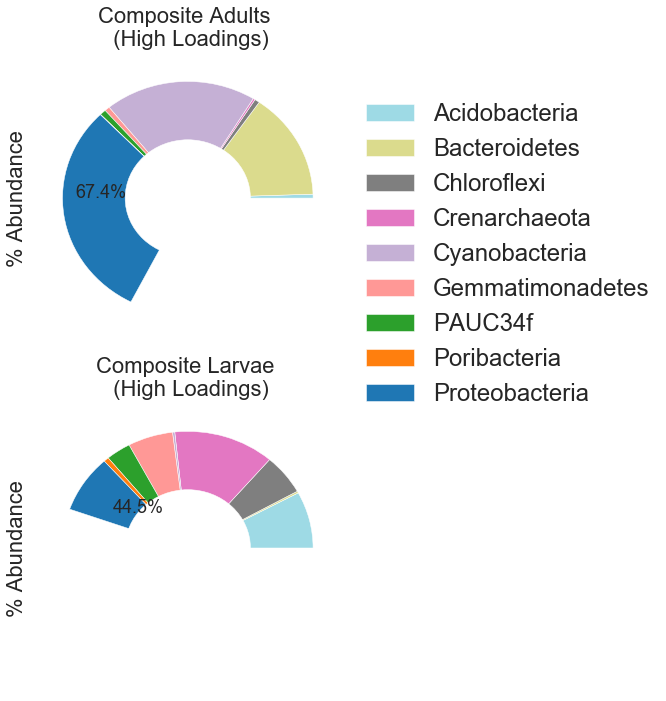

In [17]:

def get_lowest_taxa(taxa,num=10):
    taxaout_=[]
    return [x.split(';p__')[1].split(';')[0] for x in taxa]
        
Adult_loaded=feature_loading.T[feature_loading.sort_values(0,ascending=False).index[:20]].T
Larvae_loaded=feature_loading.T[feature_loading.sort_values(0,ascending=True).index[:20]].T
sorted_df_plot=pd.DataFrame(closure(sorted_df)*100,sorted_df.index,sorted_df.columns).T.copy()
sorted_df_plot.columns=list(life_stage.values)

index_all=list(Adult_loaded.index)+list(Larvae_loaded.index)

Adult_loaded=pd.DataFrame(sorted_df_plot[['Adult']].T.mean()[index_all]
                         ,columns=['Composite Adults \n (High Loadings)'])

Larvae_loaded=pd.DataFrame(sorted_df_plot[['Larvae']].T.mean()[index_all]
                         ,columns=['Composite Larvae \n (High Loadings)'])

Adult_loaded.index=[taxonomy['taxonomy'][x] for x in Adult_loaded.index]
Adult_loaded.index=get_lowest_taxa(Adult_loaded.index)
Larvae_loaded.index=[taxonomy['taxonomy'][x] for x in Larvae_loaded.index]
Larvae_loaded.index=get_lowest_taxa(Larvae_loaded.index)
composite_loadings=pd.concat([Adult_loaded,Larvae_loaded],axis=1)
composite_loadings=composite_loadings.groupby(composite_loadings.index).sum()

fig,axn=plt.subplots(2,1,figsize=(5,11))

locs=[(-.9,0),(-.6,0.3)]
percs=[str(x)[:4]+'%' for x in list(composite_loadings.sum())]
for (count_,group_),ax in zip(enumerate(composite_loadings.columns),axn.flat):
    all_pie=composite_loadings.copy()
    
    all_pie[group_]=all_pie[group_]/100
    
    # Create a circle for the center of the plot
    my_circle=plt.Circle( (0,0), 0.5, color='white')

    all_pie[group_].T.plot.pie(ax=ax,
                                    labels=['' for x in composite_loadings[group_].values],
                                   colormap='tab20_r')
    #handles, labels = ax.get_legend_handles_labels()
    plt.legend(labels=all_pie.index,title="", loc=2,prop={'size':24},bbox_to_anchor=(1.0, 2.1)) 

    ax.set_ylabel('% Abundance',fontsize=22)
    ax.add_artist(my_circle)
    ax.annotate(percs[count_], locs[count_],fontsize=18)
    ax.set_title(group_,fontsize=22)
plt.savefig('figures/supp_sponge_taxonomy_loadings.png',dpi=300, bbox_inches='tight')
plt.show()

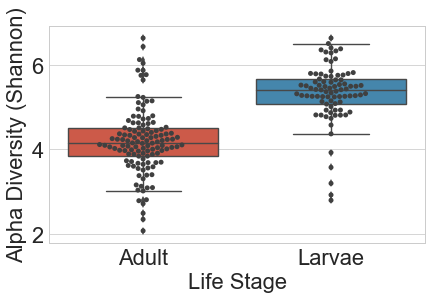

In [8]:
from skbio.diversity import alpha_diversity

plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22



alpha_=list(alpha_diversity('shannon',otutabledf.fillna(0).astype(int).as_matrix(),otutabledf.index).values)  
mappingdf['Alpha Diversity (Shannon)']=alpha_
sns.boxplot(y='Alpha Diversity (Shannon)',x='Life Stage',data=mappingdf)
sns.swarmplot(y='Alpha Diversity (Shannon)',x='Life Stage',data=mappingdf, color=".25")
plt.savefig('figures/supp_sponge_alpha.png',dpi=300, bbox_inches='tight')
plt.show()

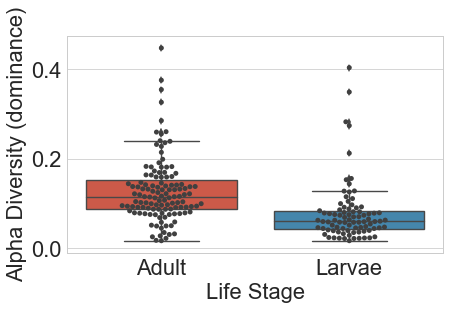

In [9]:



from skbio.diversity import alpha_diversity

plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22



alpha_=list(alpha_diversity('dominance',otutabledf.fillna(0).astype(int).as_matrix(),otutabledf.index).values)  
mappingdf['Alpha Diversity (dominance)']=alpha_
sns.boxplot(y='Alpha Diversity (dominance)',x='Life Stage',data=mappingdf)
sns.swarmplot(y='Alpha Diversity (dominance)',x='Life Stage',data=mappingdf, color=".25")
plt.savefig('figures/supp_sponge_dom.png',dpi=300, bbox_inches='tight')
plt.show()